In [29]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def load_hotdog_data():
    train_dataset = h5py.File('datasets/train_hotdogvsnothotdog.hdf5', "r")
    train_set_x_orig = np.array(train_dataset["train_img"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_labels"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_hotdogvsnothotdog.hdf5', "r")
    test_set_x_orig = np.array(test_dataset["test_img"][:int(train_set_x_orig.shape[0]*.2)]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_labels"][:int(train_set_x_orig.shape[0]*.2)]) # your test set labels

    classes = np.array([b'hotdog', b'not_hotdog']) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [31]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_hotdog_data()

y = 1. It's a not_hotdog picture.


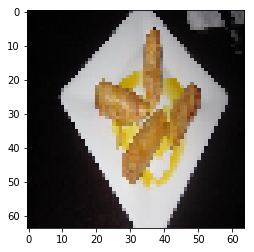

In [32]:
# Example of a picture
index = 150
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [33]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 498
Number of testing examples: 99
Each image is of size: (64, 64, 3)
train_x_orig shape: (498, 64, 64, 3)
train_y shape: (1, 498)
test_x_orig shape: (99, 64, 64, 3)
test_y shape: (1, 99)


In [34]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 498)
test_x's shape: (12288, 99)


In [35]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 20
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [36]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.69319951936471
Cost after iteration 100: 0.6901682507267317
Cost after iteration 200: 0.6833591874593024
Cost after iteration 300: 0.6655605306129125
Cost after iteration 400: 0.6344367473520006
Cost after iteration 500: 0.5974119856897532
Cost after iteration 600: 0.5552333495029783
Cost after iteration 700: 0.5071434064326176
Cost after iteration 800: 0.5125267920688135
Cost after iteration 900: 0.4879573946046134
Cost after iteration 1000: 0.4677331019721356
Cost after iteration 1100: 0.4494407698601272
Cost after iteration 1200: 0.4283767268617226
Cost after iteration 1300: 0.4089209612452108
Cost after iteration 1400: 0.38309735700776215
Cost after iteration 1500: 0.36413702910984885
Cost after iteration 1600: 0.3439344202082852
Cost after iteration 1700: 0.30831023228815596
Cost after iteration 1800: 0.24536685452794768
Cost after iteration 1900: 0.26153866547629073
Cost after iteration 2000: 0.1900119387618668


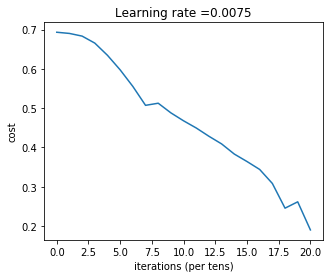

In [37]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), learning_rate = 0.0075, num_iterations = 2100, print_cost=True)

In [38]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9718875502008033


In [39]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.5454545454545455


In [40]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.720345
Cost after iteration 100: 0.636218
Cost after iteration 200: 0.604580
Cost after iteration 300: 0.555296
Cost after iteration 400: 0.524173
Cost after iteration 500: 0.473442
Cost after iteration 600: 0.455406
Cost after iteration 700: 0.388801
Cost after iteration 800: 0.364282
Cost after iteration 900: 0.352215
Cost after iteration 1000: 0.352849
Cost after iteration 1100: 0.299838


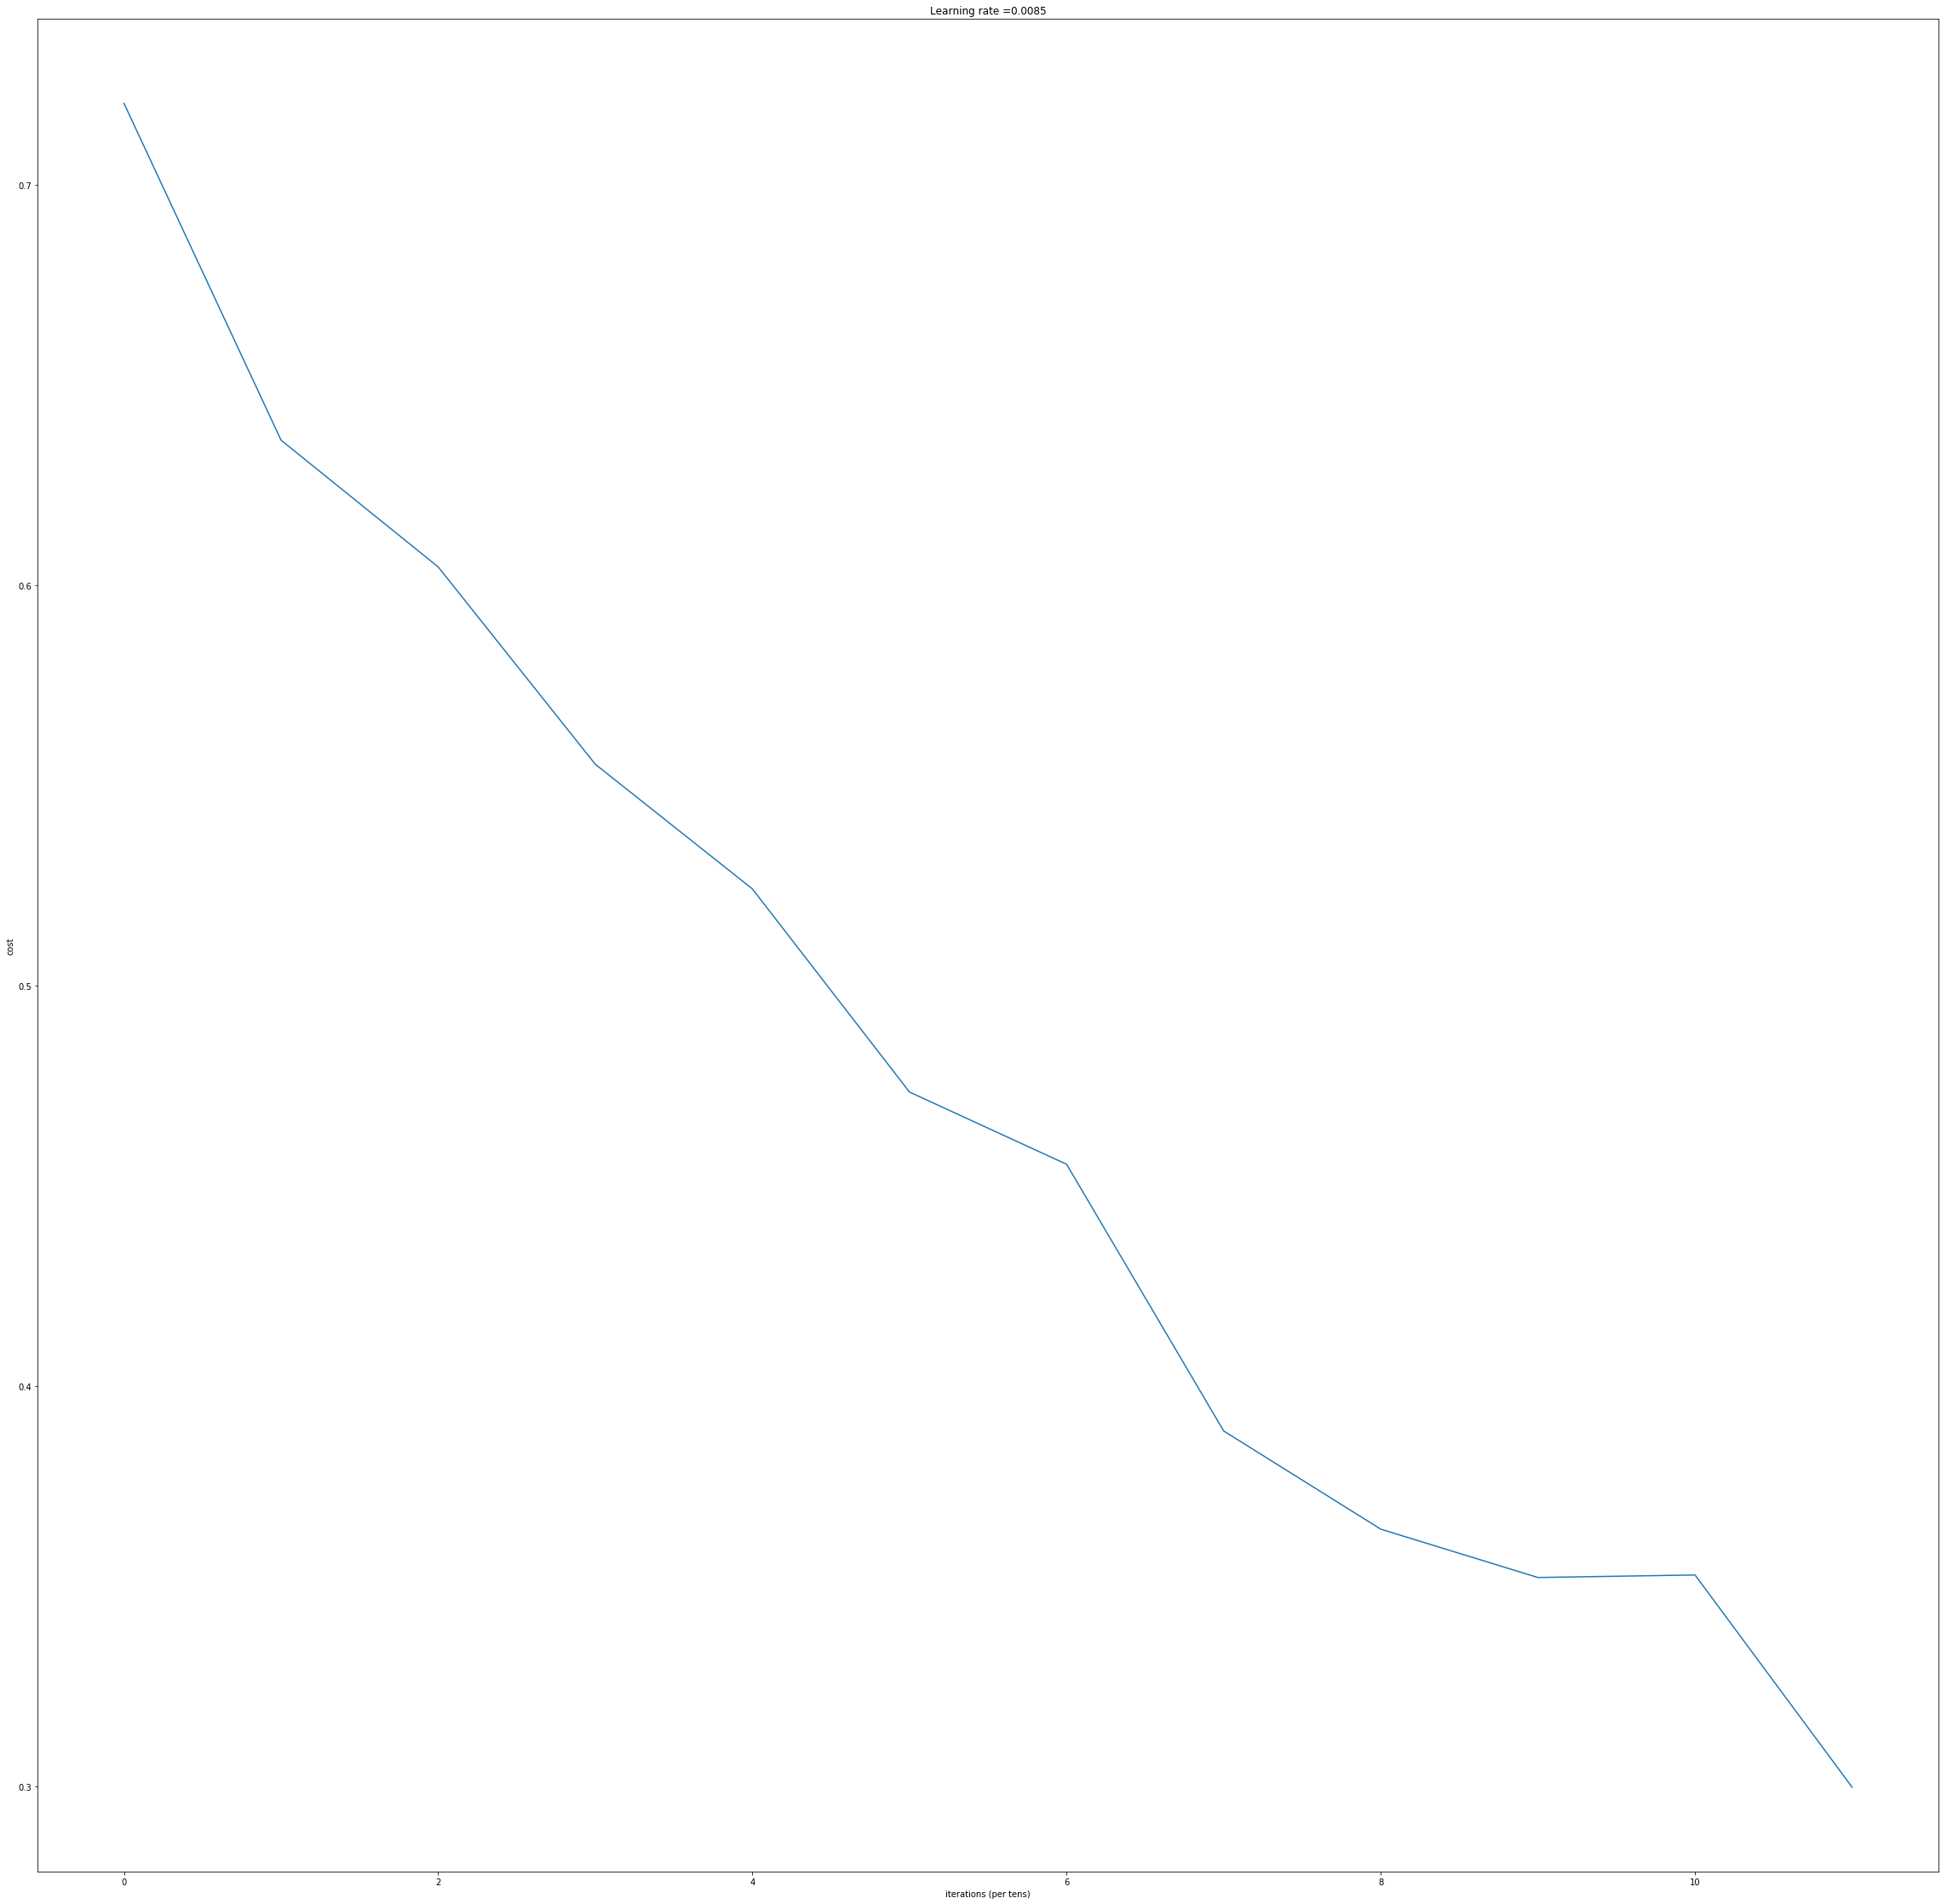

In [128]:
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1200, print_cost = True, learning_rate = 0.0085)

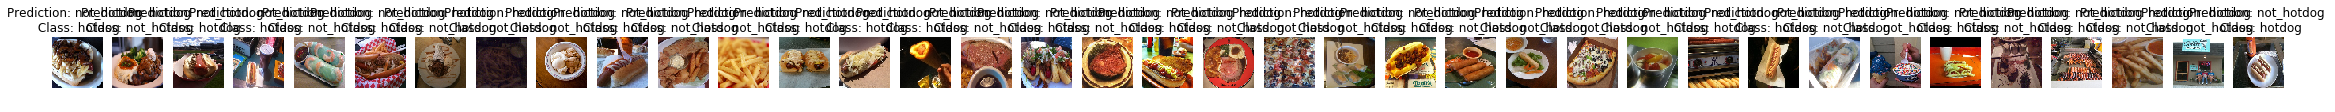

In [118]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

In [126]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9156626506024097


In [127]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.5656565656565656


Cost after iteration 0: 0.697100
Cost after iteration 100: 0.649793
Cost after iteration 200: 0.596065
Cost after iteration 300: 0.554450
Cost after iteration 400: 0.524360
Cost after iteration 500: 0.495906
Cost after iteration 600: 0.467326
Cost after iteration 700: 0.414632
Cost after iteration 800: 0.433712
Cost after iteration 900: 0.305193
Cost after iteration 1000: 0.278196
Cost after iteration 1100: 0.204481
Cost after iteration 1200: 0.536542
Cost after iteration 1300: 0.457889
Cost after iteration 1400: 0.109251
Cost after iteration 1500: 0.090568
Cost after iteration 1600: 0.075587
Cost after iteration 1700: 0.055874


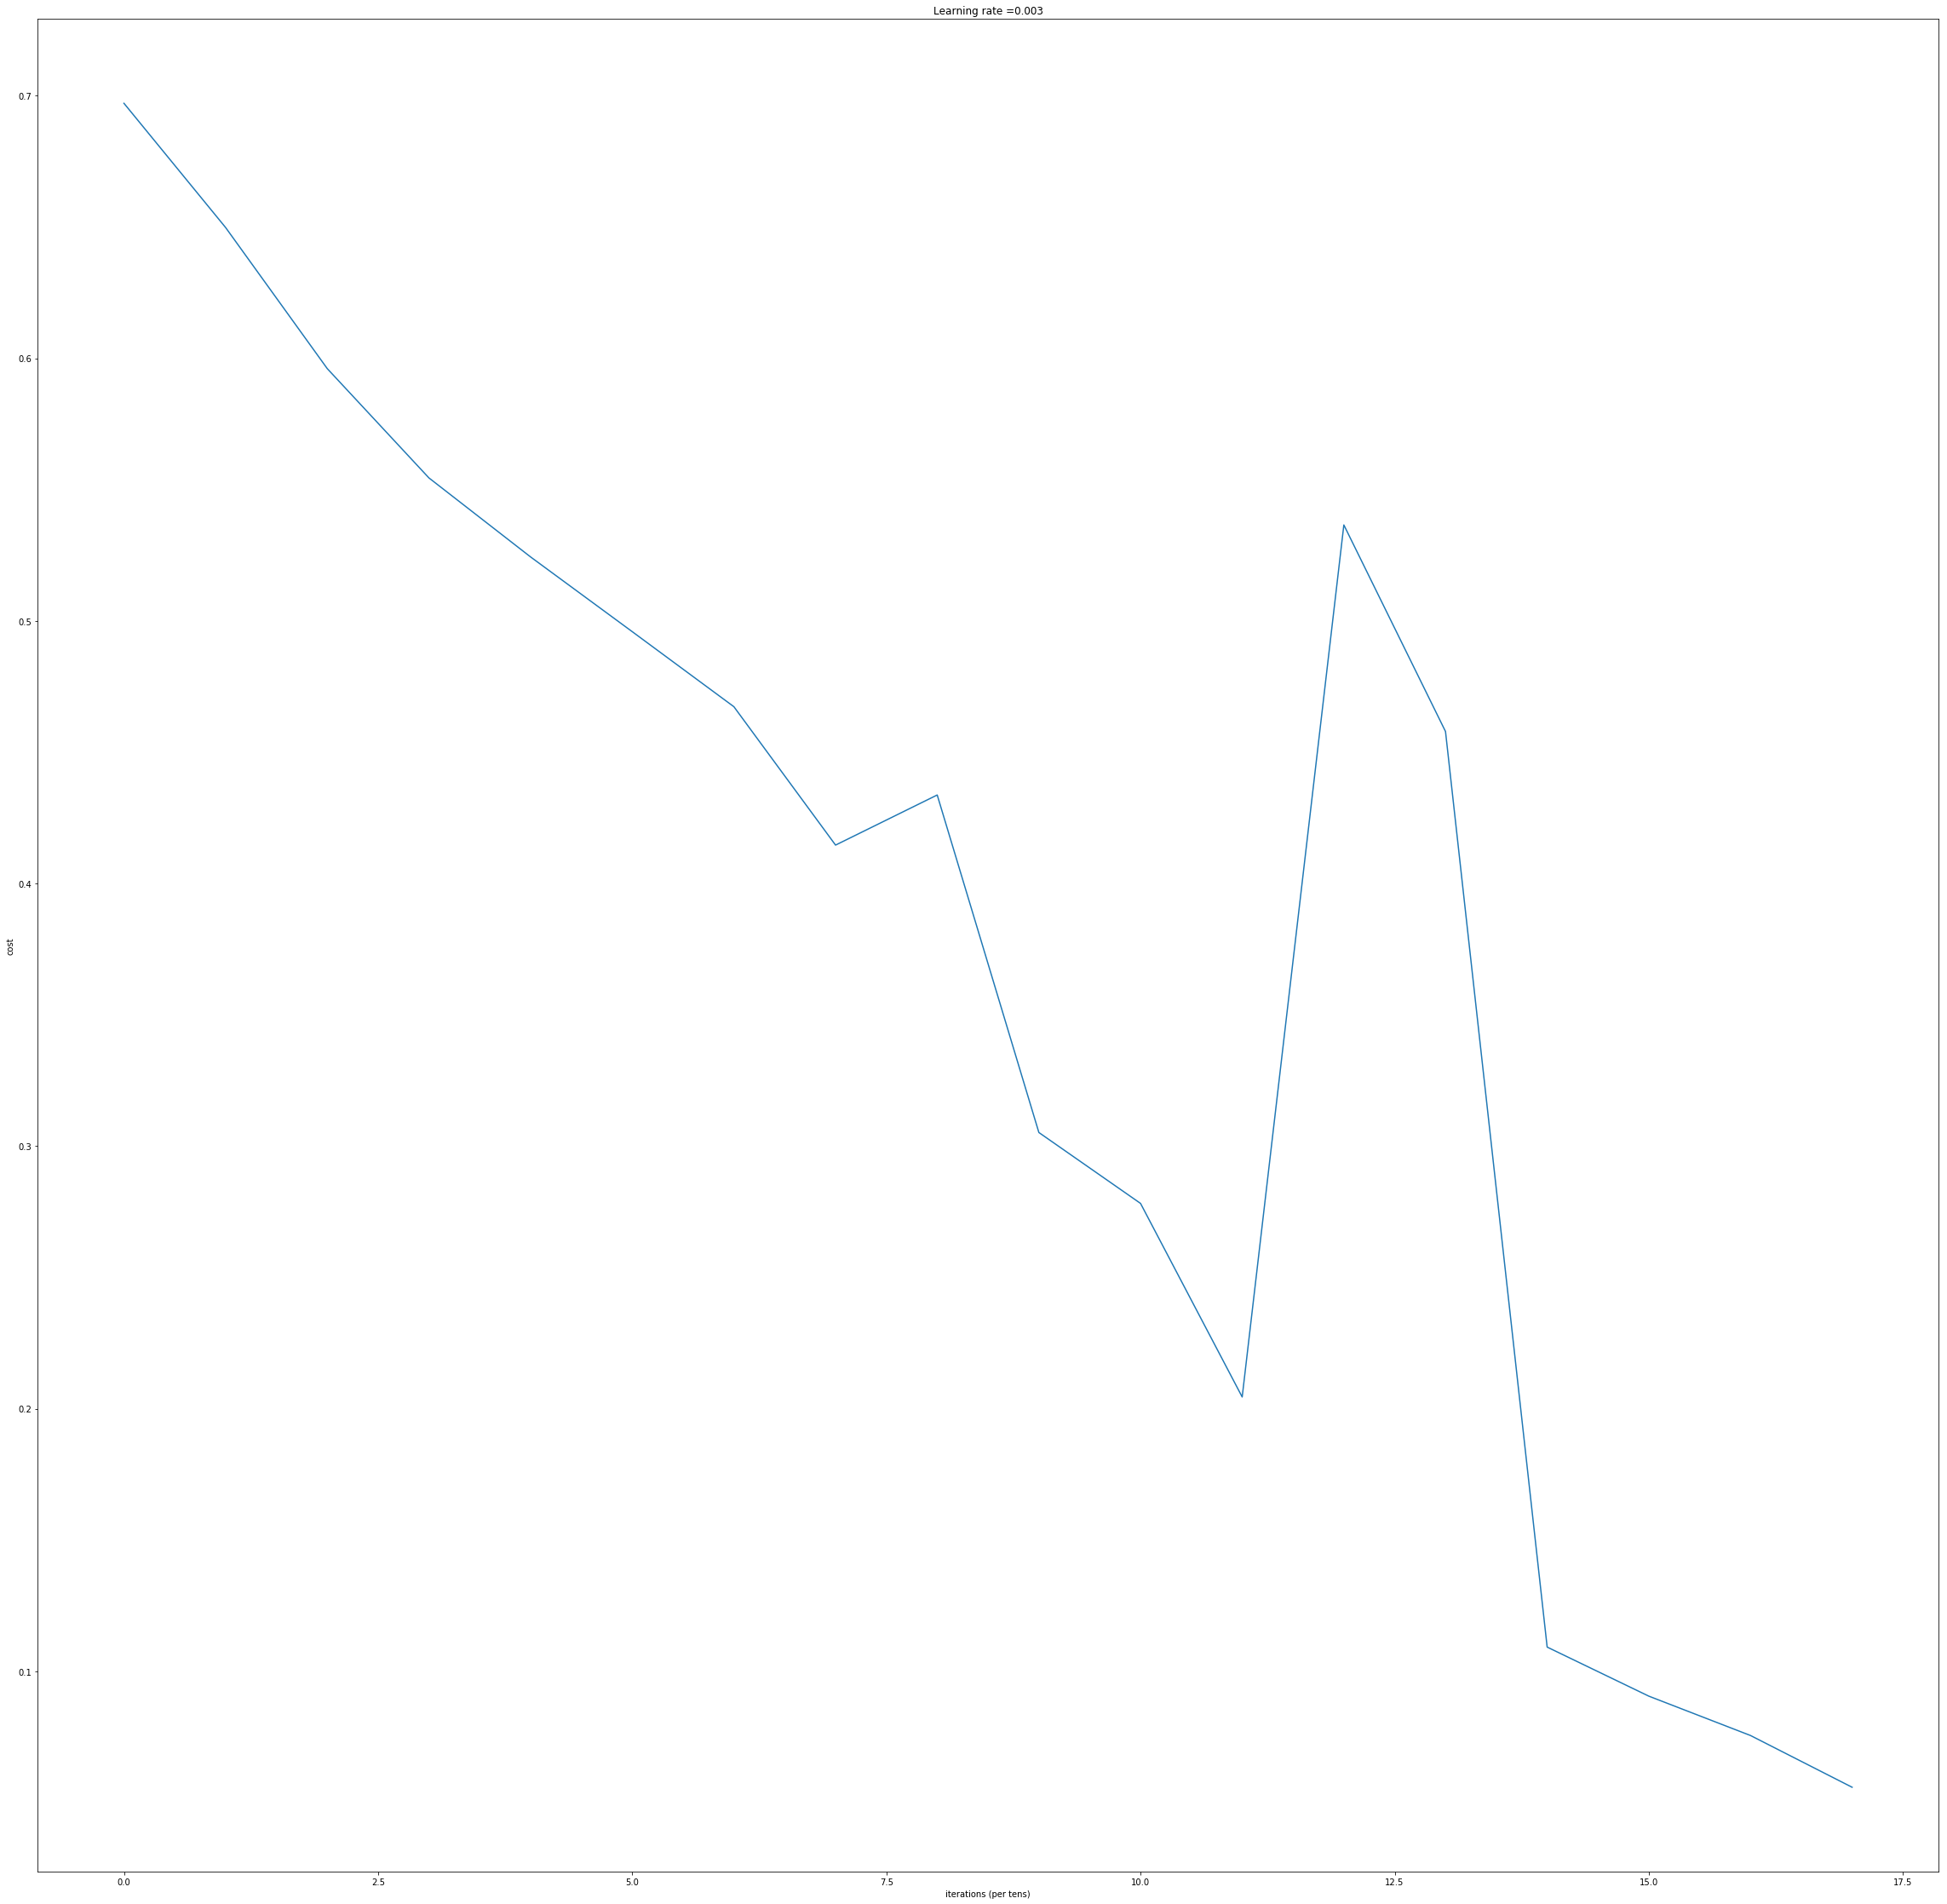

In [146]:
layers_dims = [12288, 70, 20, 7, 5, 1] #  4-layer model
#modify the learning rate and the number of iterations
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.003, num_iterations = 1800, print_cost = True)

In [147]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.997991967871486


In [148]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.5454545454545454


Cost after iteration 0: 0.698049
Cost after iteration 100: 0.646242
Cost after iteration 200: 0.610207
Cost after iteration 300: 0.548848
Cost after iteration 400: 0.587660
Cost after iteration 500: 0.512485
Cost after iteration 600: 0.447382
Cost after iteration 700: 0.405236
Cost after iteration 800: 0.397843
Cost after iteration 900: 0.358180
Cost after iteration 1000: 0.319191
Cost after iteration 1100: 0.353320
Cost after iteration 1200: 0.618899
Cost after iteration 1300: 0.272424
Cost after iteration 1400: 0.251481
Cost after iteration 1500: 0.214828
Cost after iteration 1600: 0.191231
Cost after iteration 1700: 0.176295
Cost after iteration 1800: 0.164566
Cost after iteration 1900: 0.151229


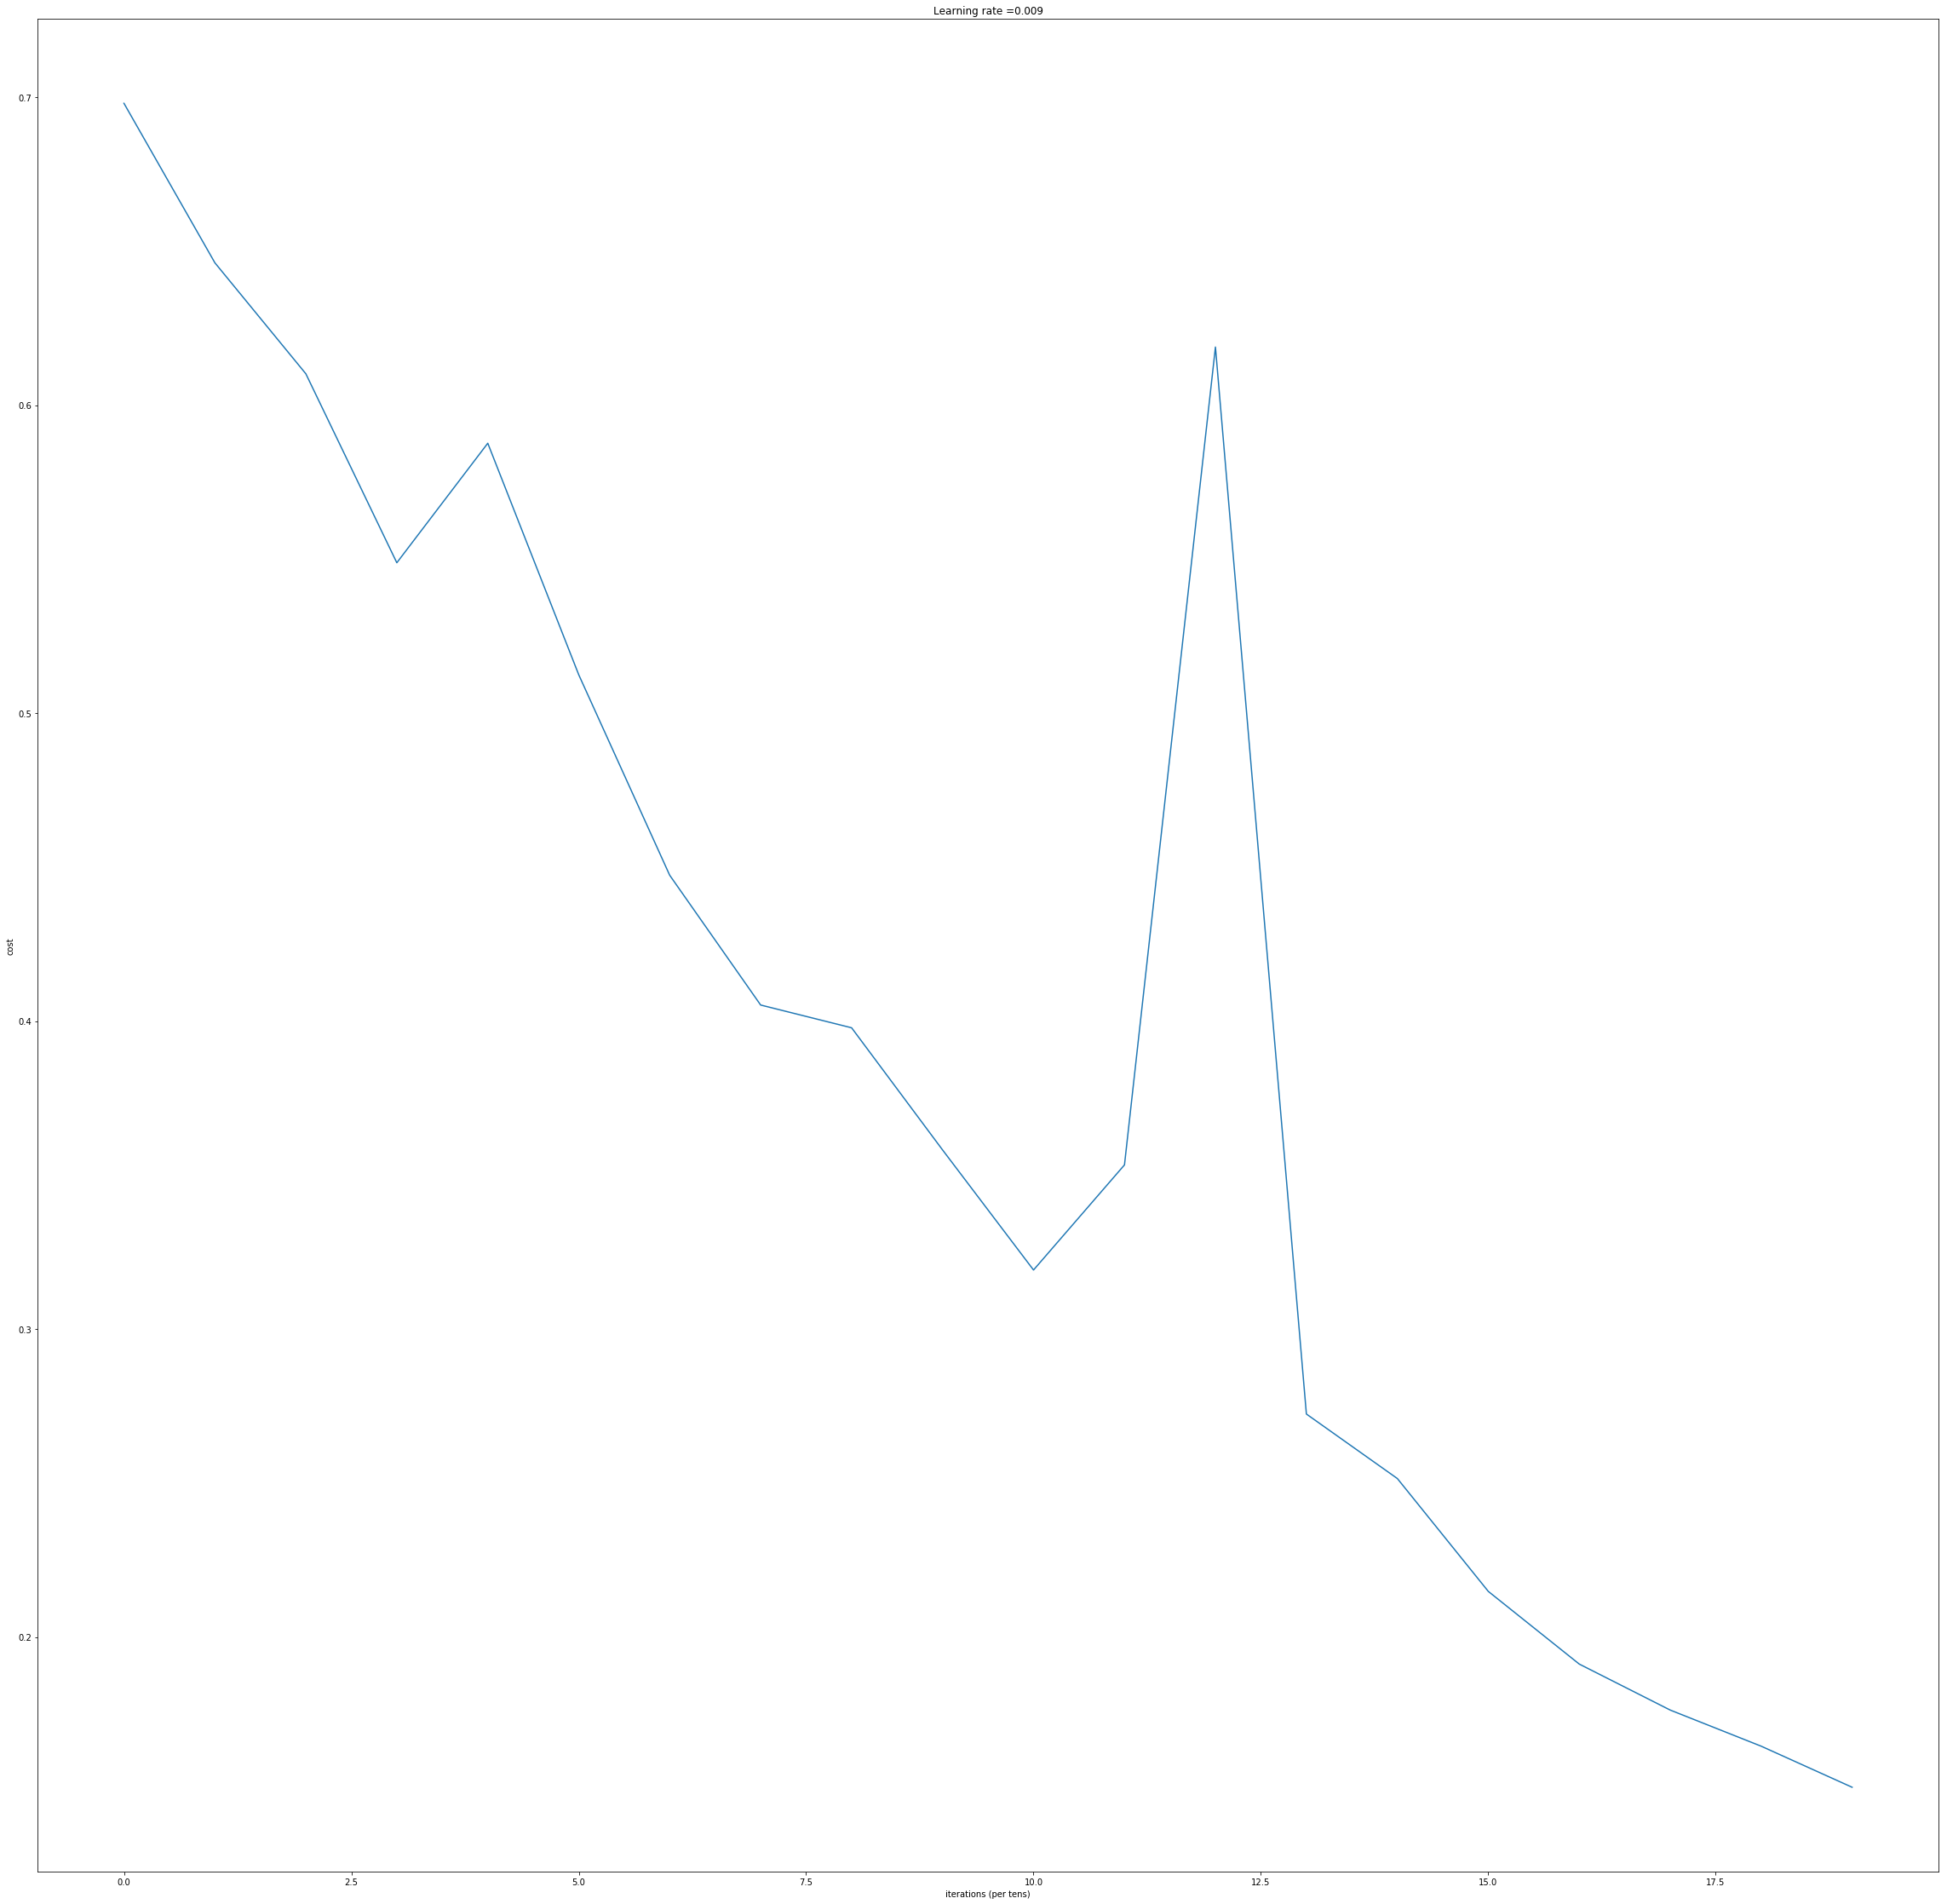

In [200]:
#modify the number of neurons in each layer
layers_dims = [12288, 32, 2, 1] #  4-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.009, num_iterations = 2000, print_cost = True)

In [198]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9779116465863456


In [199]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.5252525252525252


Cost after iteration 0: 0.6928545563802507
Cost after iteration 100: 0.6913045745036844
Cost after iteration 200: 0.6882640616840717
Cost after iteration 300: 0.6811418933699721
Cost after iteration 400: 0.6668677848706976
Cost after iteration 500: 0.641413591957915
Cost after iteration 600: 0.6095673829111553
Cost after iteration 700: 0.574127210000233
Cost after iteration 800: 0.5345344053143972
Cost after iteration 900: 0.653205322305108
Cost after iteration 1000: 0.5430910895917902
Cost after iteration 1100: 0.5282208456774723
Cost after iteration 1200: 0.5142989309843371
Cost after iteration 1300: 0.5013441708989455
Cost after iteration 1400: 0.4882687421894153
Cost after iteration 1500: 0.47629794707949547
Cost after iteration 1600: 0.4645705240239884
Cost after iteration 1700: 0.4528589891725067
Cost after iteration 1800: 0.4422839148931822
Cost after iteration 1900: 0.43175264519634954
Cost after iteration 2000: 0.42141039828216664
Cost after iteration 2100: 0.41162371770332307

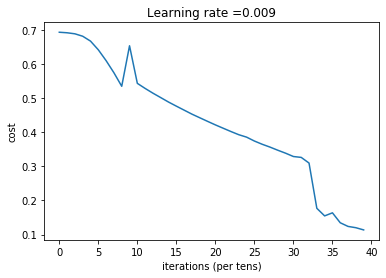

In [27]:
#go back to the 3 layers model
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), learning_rate = 0.009, 
                             num_iterations = 4000, print_cost=True)




In [28]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9859437751004018


In [29]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.52


Cost after iteration 0: 0.693115
Cost after iteration 100: 0.687780
Cost after iteration 200: 0.679638
Cost after iteration 300: 0.664651
Cost after iteration 400: 0.646350
Cost after iteration 500: 0.631486
Cost after iteration 600: 0.616851
Cost after iteration 700: 0.596658
Cost after iteration 800: 0.578516
Cost after iteration 900: 0.556990
Cost after iteration 1000: 0.542623
Cost after iteration 1100: 0.522619
Cost after iteration 1200: 0.491435
Cost after iteration 1300: 0.494353
Cost after iteration 1400: 0.473133
Cost after iteration 1500: 0.463403
Cost after iteration 1600: 0.458245
Cost after iteration 1700: 0.514530
Cost after iteration 1800: 0.412711
Cost after iteration 1900: 0.349704
Cost after iteration 2000: 0.420667
Cost after iteration 2100: 0.200507
Cost after iteration 2200: 0.206889
Cost after iteration 2300: 0.283325
Cost after iteration 2400: 0.168960
Cost after iteration 2500: 0.133438
Cost after iteration 2600: 0.625432
Cost after iteration 2700: 0.063056
Cost

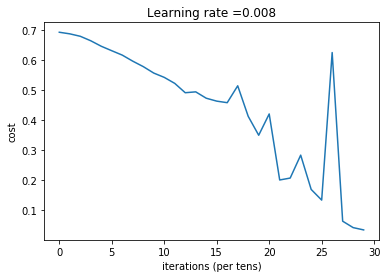

In [30]:
layers_dims = [16875, 20, 10, 7, 5, 3, 1] #  6-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.008, num_iterations = 3000, print_cost = True)

In [31]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.993975903614458


In [32]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.524


Cost after iteration 0: 0.693115
Cost after iteration 100: 0.690167
Cost after iteration 200: 0.686204
Cost after iteration 300: 0.681121
Cost after iteration 400: 0.673510
Cost after iteration 500: 0.661889
Cost after iteration 600: 0.645430
Cost after iteration 700: 0.631229
Cost after iteration 800: 0.618244
Cost after iteration 900: 0.603220
Cost after iteration 1000: 0.586207
Cost after iteration 1100: 0.575332
Cost after iteration 1200: 0.553385
Cost after iteration 1300: 0.532726
Cost after iteration 1400: 0.518854
Cost after iteration 1500: 0.510342
Cost after iteration 1600: 0.493902
Cost after iteration 1700: 0.470918
Cost after iteration 1800: 0.473437
Cost after iteration 1900: 0.429028
Cost after iteration 2000: 0.460632
Cost after iteration 2100: 0.415219
Cost after iteration 2200: 0.370248
Cost after iteration 2300: 0.398449
Cost after iteration 2400: 0.278259


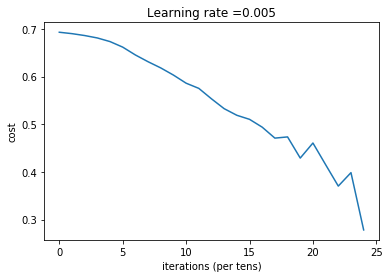

In [33]:
layers_dims = [16875, 20, 10, 7, 5, 3, 1] #  6-layer model
#modify learning_rate and num_iterations
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 2500, print_cost = True)

In [34]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9036144578313254


In [35]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.542


Cost after iteration 0: 0.692356
Cost after iteration 100: 0.686468
Cost after iteration 200: 0.681468
Cost after iteration 300: 0.676155
Cost after iteration 400: 0.670140
Cost after iteration 500: 0.663066
Cost after iteration 600: 0.654545
Cost after iteration 700: 0.644010
Cost after iteration 800: 0.630730
Cost after iteration 900: 0.613745
Cost after iteration 1000: 0.591790
Cost after iteration 1100: 0.580274
Cost after iteration 1200: 0.571574
Cost after iteration 1300: 0.550629
Cost after iteration 1400: 0.533074
Cost after iteration 1500: 0.512103
Cost after iteration 1600: 0.490028
Cost after iteration 1700: 0.470801
Cost after iteration 1800: 0.443459
Cost after iteration 1900: 0.426483
Cost after iteration 2000: 0.416854
Cost after iteration 2100: 0.399588
Cost after iteration 2200: 0.360603
Cost after iteration 2300: 0.333006
Cost after iteration 2400: 0.327402


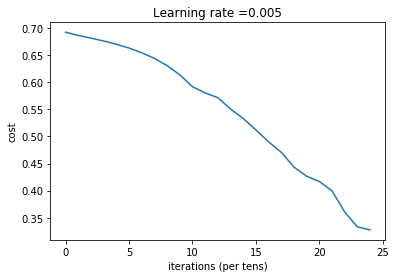

In [36]:
#modify number of neurons in each layer
layers_dims = [16875, 20, 12, 12, 5, 3, 1] #  6-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.005, num_iterations = 2500, print_cost = True)

In [37]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9116465863453818


In [38]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.524


Cost after iteration 0: 0.692356
Cost after iteration 100: 0.688991
Cost after iteration 200: 0.686465
Cost after iteration 300: 0.683944
Cost after iteration 400: 0.681458
Cost after iteration 500: 0.678872
Cost after iteration 600: 0.676138
Cost after iteration 700: 0.673223
Cost after iteration 800: 0.670118
Cost after iteration 900: 0.666728
Cost after iteration 1000: 0.663035
Cost after iteration 1100: 0.658981
Cost after iteration 1200: 0.654501
Cost after iteration 1300: 0.649536
Cost after iteration 1400: 0.643946
Cost after iteration 1500: 0.637676
Cost after iteration 1600: 0.630596
Cost after iteration 1700: 0.622526
Cost after iteration 1800: 0.613269
Cost after iteration 1900: 0.602789
Cost after iteration 2000: 0.590914
Cost after iteration 2100: 0.577379
Cost after iteration 2200: 0.561838
Cost after iteration 2300: 0.544724
Cost after iteration 2400: 0.529032
Cost after iteration 2500: 0.516163
Cost after iteration 2600: 0.508236
Cost after iteration 2700: 0.498164
Cost

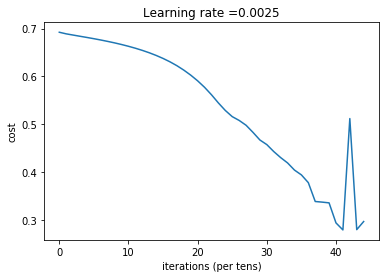

In [61]:
#modify number of neurons in each layer
layers_dims = [16875, 20, 12, 12, 5, 3, 1] #  6-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.0025, num_iterations = 4500, print_cost = True)

In [62]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9678714859437753


In [63]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.53


Cost after iteration 0: 0.692945
Cost after iteration 100: 0.692499
Cost after iteration 200: 0.692186
Cost after iteration 300: 0.691943
Cost after iteration 400: 0.691722
Cost after iteration 500: 0.691504
Cost after iteration 600: 0.691268
Cost after iteration 700: 0.690988
Cost after iteration 800: 0.690710
Cost after iteration 900: 0.690446
Cost after iteration 1000: 0.690176
Cost after iteration 1100: 0.689894
Cost after iteration 1200: 0.689588
Cost after iteration 1300: 0.689261
Cost after iteration 1400: 0.688916
Cost after iteration 1500: 0.688517
Cost after iteration 1600: 0.687861
Cost after iteration 1700: 0.687306
Cost after iteration 1800: 0.686737
Cost after iteration 1900: 0.686142
Cost after iteration 2000: 0.685507
Cost after iteration 2100: 0.684828
Cost after iteration 2200: 0.684109
Cost after iteration 2300: 0.683344
Cost after iteration 2400: 0.682519
Cost after iteration 2500: 0.681646
Cost after iteration 2600: 0.680713
Cost after iteration 2700: 0.679707
Cost

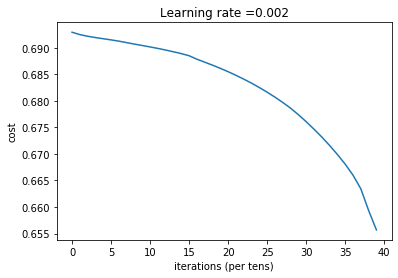

In [67]:
#modify number of neurons in each layer
layers_dims = [16875, 20, 15, 12, 7, 5, 3, 1] #  7-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.002, num_iterations = 4000, print_cost = True)

In [68]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6686746987951808


In [69]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.526
